# Kernel PCA on Indicators for Co-Movement Discovery

Goal:
- Use Kernel PCA on the repo's **feature-extracted indicator dataset** to embed assets so that assets with similar indicator states cluster together.
- Identify which indicators are most associated with the embedding dimensions.

Outputs:
- clusters of assets (candidate co-moving / cointegrated groups)
- per-cluster common price charts (daily close over full history)
- top indicators associated with each Kernel PCA component (via Spearman correlation with embedding coordinates)

Time split:
- fit KernelPCA + clustering using the train window (first 7 years)
- plots use full available history


In [1]:
from __future__ import annotations

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr


In [2]:
CWD = Path.cwd().resolve()
PROJECT_ROOT = None
for p in [CWD, *CWD.parents]:
    if (p / 'dataset').exists() and (p / 'src').exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise RuntimeError(f'Could not locate project root from CWD={CWD}')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('PROJECT_ROOT:', PROJECT_ROOT)


PROJECT_ROOT: /home/anivarth/college/quant-task


In [3]:
# Load feature-extracted dataset
FEATURES_PARQUET_PATH = PROJECT_ROOT / 'dataset' / 'features' / 'all_features.parquet'
FEATURES_CSV_PATH = PROJECT_ROOT / 'dataset' / 'features' / 'all_features.csv'

if FEATURES_PARQUET_PATH.exists():
    df = pd.read_parquet(FEATURES_PARQUET_PATH)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
elif FEATURES_CSV_PATH.exists():
    df = pd.read_csv(FEATURES_CSV_PATH, parse_dates=['Date']).set_index('Date')
else:
    raise FileNotFoundError('Feature dataset not found under dataset/features/.')

# Ensure required
if 'Asset_ID' not in df.columns:
    raise ValueError('Expected Asset_ID column in feature dataset')

# Time split window
TRAIN_YEARS = 7
TEST_MONTHS = 18
start = pd.Timestamp(df.index.min())
end = pd.Timestamp(df.index.max())
train_end = start + pd.DateOffset(years=TRAIN_YEARS)
test_start = end - pd.DateOffset(months=TEST_MONTHS)

if train_end >= test_start:
    raise ValueError('Not enough history for requested time split')

train_df = df.loc[df.index < train_end].copy()

print('date range:', start.date(), '->', end.date())
print('train:', train_df.index.min().date(), '->', train_df.index.max().date(), 'rows:', train_df.shape[0])
print('assets:', df['Asset_ID'].nunique())


date range: 2016-01-25 -> 2026-01-16
train: 2016-01-25 -> 2023-01-24 rows: 176300
assets: 100


In [4]:
# Build per-asset indicator vectors using TRAIN window.
# We use robust aggregation per asset: median of each indicator over time.

exclude = {'Asset_ID'}
feature_cols = [c for c in train_df.columns if c not in exclude]

numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(train_df[c])]
print('n_numeric_indicator_cols:', len(numeric_cols))

# Aggregate per asset
asset_vectors = train_df.groupby('Asset_ID')[numeric_cols].median(numeric_only=True)
asset_vectors = asset_vectors.replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely missing
asset_vectors = asset_vectors.dropna(axis=1, how='all')

print('asset_vectors shape:', asset_vectors.shape)

# Impute + scale
imp = SimpleImputer(strategy='median')
X = imp.fit_transform(asset_vectors.to_numpy())

scaler = StandardScaler()
X = scaler.fit_transform(X)

assets = asset_vectors.index.to_list()
cols_used = asset_vectors.columns.to_list()
print('used_cols:', len(cols_used))


n_numeric_indicator_cols: 127
asset_vectors shape: (100, 127)
used_cols: 127


In [5]:
# Kernel PCA embedding
N_COMPONENTS = 8
GAMMA = None  # set numeric gamma for RBF if desired

kpca = KernelPCA(n_components=N_COMPONENTS, kernel='rbf', gamma=GAMMA, random_state=42)
Z = kpca.fit_transform(X)
print('Z shape:', Z.shape)

# Cluster in embedding
N_CLUSTERS = 8
km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
labels = km.fit_predict(Z)

groups: dict[int, list[str]] = {}
for a, lab in zip(assets, labels):
    groups.setdefault(int(lab), []).append(a)

print('cluster sizes:', {k: len(v) for k, v in groups.items()})


Z shape: (100, 8)
cluster sizes: {0: 8, 7: 12, 3: 16, 4: 15, 1: 22, 2: 13, 5: 6, 6: 8}


In [6]:
# Cointegration check (Engle-Granger) within KernelPCA clusters on TRAIN window
from statsmodels.tsa.stattools import coint

# Load daily closes for cointegration testing
from src.backtester.data import load_cleaned_assets, align_close_prices
assets_ohlcv = load_cleaned_assets(cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_daily = align_close_prices(assets_ohlcv).sort_index()

px_train = close_daily.loc[start:train_end].ffill().bfill()

rows = []
for cid, syms in groups.items():
    syms_use = [s for s in syms if s in px_train.columns]
    if len(syms_use) < 2:
        continue

    pvals = []
    for i in range(len(syms_use)):
        for j in range(i + 1, len(syms_use)):
            y = np.log(px_train[syms_use[i]].astype(float))
            x = np.log(px_train[syms_use[j]].astype(float))
            try:
                _score, pval, _ = coint(y, x)
            except Exception:
                continue
            pvals.append(float(pval))

    if not pvals:
        continue

    rows.append(
        {
            'cluster': int(cid),
            'n_assets': int(len(syms_use)),
            'n_pairs': int(len(pvals)),
            'pval_median': float(np.median(pvals)),
            'pval_10pct': float(np.quantile(pvals, 0.10)),
            'pval_01pct': float(np.quantile(pvals, 0.01)),
        }
    )

coint_summary = pd.DataFrame(rows).sort_values(['pval_median', 'pval_10pct'], ascending=True)
display(coint_summary)


,cluster,n_assets,n_pairs,pval_median,pval_10pct,pval_01pct
1,7,12,66,0.189496,0.020939,0.001014
6,5,6,15,0.312892,0.062823,0.014872
3,4,15,105,0.347234,0.042340,0.004512
4,1,22,231,0.393202,0.056504,0.007852
0,0,8,28,0.425744,0.109710,0.004878
7,6,8,28,0.482603,0.132501,0.029342
2,3,16,120,0.492204,0.079673,0.008103
5,2,13,78,0.572379,0.050583,0.004781


In [10]:
# Indicator association: Spearman correlation between each original indicator and each embedding dimension.

assoc_rows = []
for j in range(Z.shape[1]):
    z = Z[:, j]
    for ci, col in enumerate(cols_used):
        x = X[:, ci]
        rho, p = spearmanr(x, z)
        if np.isfinite(rho):
            assoc_rows.append({'component': j, 'indicator': col, 'spearman_rho': float(rho), 'p_value': float(p)})

assoc = pd.DataFrame(assoc_rows)

# Top indicators per component
TOP_N = 15
for j in range(Z.shape[1]):
    top = assoc[assoc['component'] == j].assign(abs_rho=lambda d: d['spearman_rho'].abs()).sort_values('abs_rho', ascending=False).head(TOP_N)
    print("\ncomponent", j)
    display(top.loc[:, ['indicator', 'spearman_rho', 'p_value']])


/tmp/ipykernel_144757/808480062.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(x, z)



component 0


,indicator,spearman_rho,p_value
109,filt_logret_kalman_r0p1_q0p01,-0.836388,2.467224e-27
58,ema_ratio_20,-0.833651,5.185766e-27
100,filt_logret_ema_12,-0.828935,1.808702e-26
0,ret_1d,-0.811113,1.469364e-24
13,diff_log_close_1,-0.811113,1.469364e-24
1,logret_1d,-0.811113,1.469364e-24
2,excess_ret_1d,-0.811113,1.469364e-24
5,ret_lag_1,-0.810129,1.847812e-24
3,logret_lag_1,-0.810129,1.847812e-24
6,ret_lag_5,-0.809997,1.905308e-24



component 1


,indicator,spearman_rho,p_value
142,logret_roll_min_5,-0.438524,0.000005
152,logret_roll_min_20,-0.435752,0.000006
178,atr_14,0.423042,0.000012
190,bb_bb_bandwidth,0.422442,0.000012
141,logret_roll_std_5,0.421362,0.000013
140,logret_roll_var_5,0.421362,0.000013
147,logret_roll_min_10,-0.419994,0.000014
150,logret_roll_var_20,0.414617,0.000018
179,realized_vol_20,0.414617,0.000018
151,logret_roll_std_20,0.414617,0.000018



component 2


,indicator,spearman_rho,p_value
274,logret_roll_var_20,0.695242,1.010970e-15
275,logret_roll_std_20,0.695242,1.010970e-15
303,realized_vol_20,0.695242,1.010970e-15
269,logret_roll_var_10,0.692685,1.418775e-15
270,logret_roll_std_10,0.692685,1.418775e-15
314,bb_bb_bandwidth,0.691221,1.719994e-15
280,logret_roll_std_60,0.687297,2.865631e-15
279,logret_roll_var_60,0.687297,2.865631e-15
265,logret_roll_std_5,0.683084,4.912956e-15
264,logret_roll_var_5,0.683084,4.912956e-15



component 3


,indicator,spearman_rho,p_value
401,logret_roll_max_20,0.471731,7.260409e-07
396,logret_roll_max_10,0.461086,1.380909e-06
388,logret_roll_var_5,0.455122,1.961295e-06
389,logret_roll_std_5,0.455122,1.961295e-06
390,logret_roll_min_5,-0.448521,2.869796e-06
394,logret_roll_std_10,0.447417,3.056097e-06
393,logret_roll_var_10,0.447417,3.056097e-06
391,logret_roll_max_5,0.446301,3.255991e-06
395,logret_roll_min_10,-0.440300,4.559993e-06
438,bb_bb_bandwidth,0.434431,6.300334e-06



component 4


,indicator,spearman_rho,p_value
573,adx_minus_di,-0.270063,0.006580
557,macd_macd_hist,-0.215086,0.031632
568,obv,0.212781,0.033548
569,obv_roc_10,0.210621,0.035432
571,ad_line,0.162940,0.105283
547,logret_zscore_20,-0.157360,0.117918
524,logret_roll_min_20,0.138758,0.168573
529,logret_roll_min_60,0.135962,0.177403
550,atr_14,-0.133777,0.184533
519,logret_roll_min_10,0.127549,0.206006



component 5


,indicator,spearman_rho,p_value
699,adx_adx_raw,-0.623066,4.441669e-12
673,volume_minmax_20,0.585251,1.607695e-10
664,volume_zscore_5,0.575638,3.725388e-10
698,adx_adx,-0.562640,1.112384e-09
667,volume_zscore_20,0.485641,3.031429e-07
670,volume_zscore_60,0.407729,2.547973e-05
669,volume_roll_std_60,-0.388251,6.567004e-05
666,volume_roll_std_20,-0.376874,1.111465e-04
668,volume_roll_mean_60,-0.364128,1.959307e-04
665,volume_roll_mean_20,-0.362736,2.081524e-04



component 6


,indicator,spearman_rho,p_value
795,logret_zscore_20,-0.338206,0.000578
805,macd_macd_hist,-0.307267,0.001873
822,adx_adx,-0.284008,0.004189
806,rmacd_12_26_9,-0.279052,0.004931
797,volume_minmax_20,0.248785,0.012562
796,close_minmax_20,0.240180,0.016086
800,rsi_14,0.238488,0.016872
838,fib_retr_60,-0.216634,0.030397
811,bb_bb_percent_b,0.203000,0.042803
813,stoch_stoch_k,0.202928,0.042879



component 7


,indicator,spearman_rho,p_value
919,logret_zscore_20,-0.544074,4.901414e-09
973,filt_resid_savgol_11_2,-0.332553,7.236076e-04
872,logret_lag_5,-0.331197,7.630716e-04
874,ret_lag_5,-0.331197,7.630716e-04
918,volume_zscore_60,-0.330537,7.829829e-04
871,logret_lag_1,-0.329877,8.033681e-04
873,ret_lag_1,-0.329877,8.033681e-04
870,excess_ret_1d,-0.323192,1.038893e-03
868,ret_1d,-0.323192,1.038893e-03
881,diff_log_close_1,-0.323192,1.038893e-03


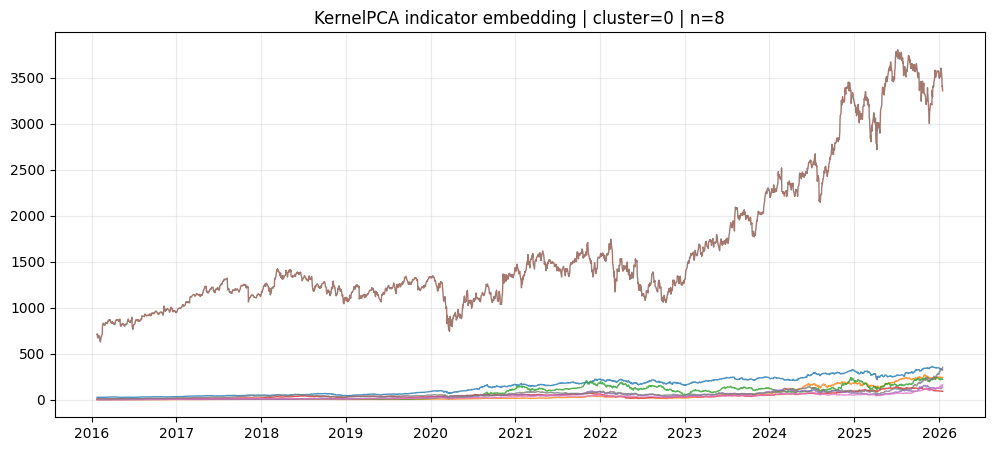

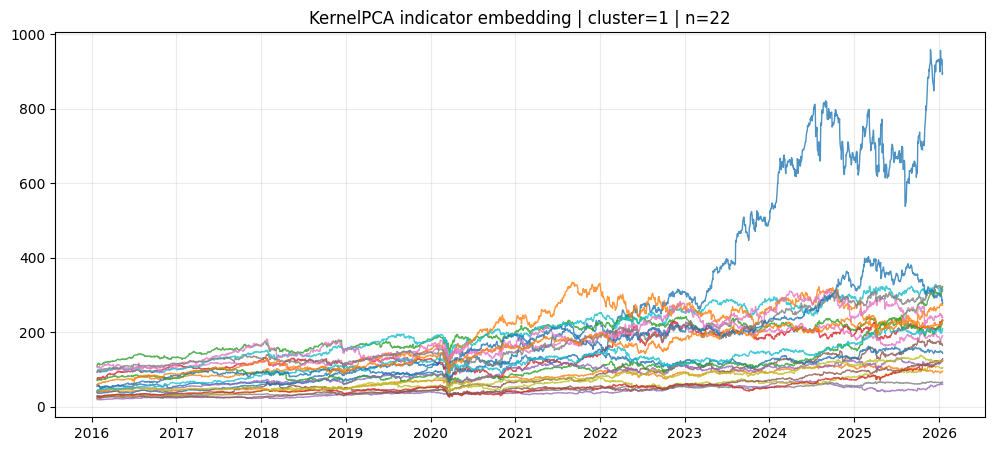

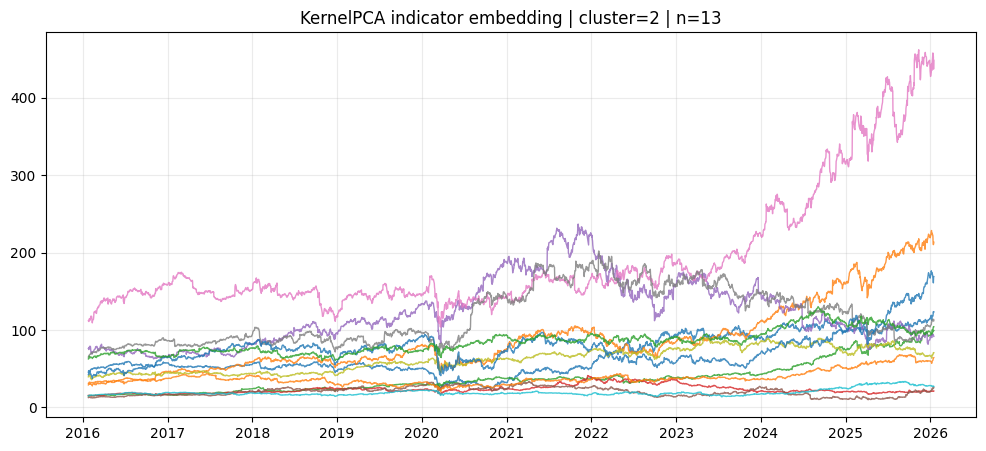

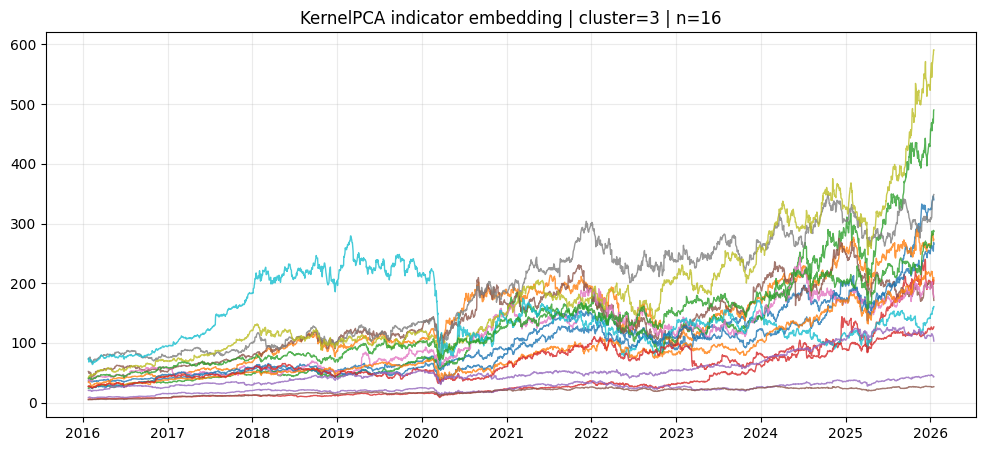

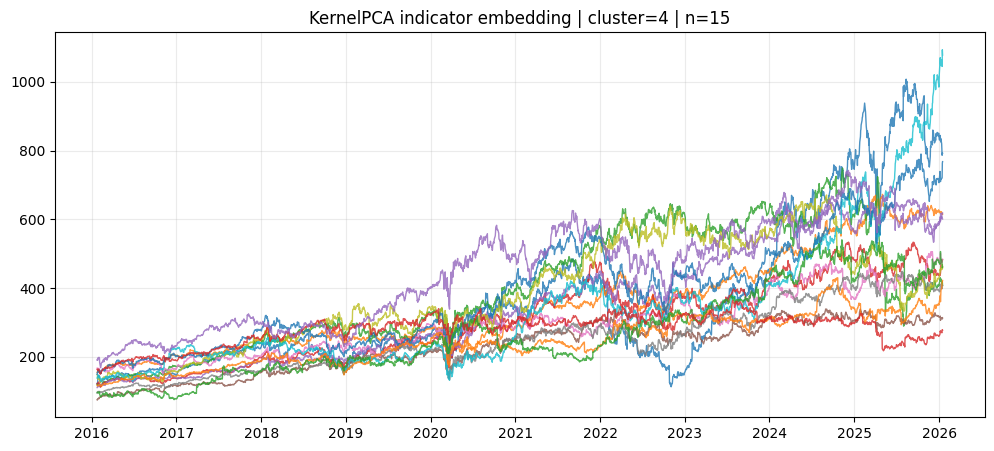

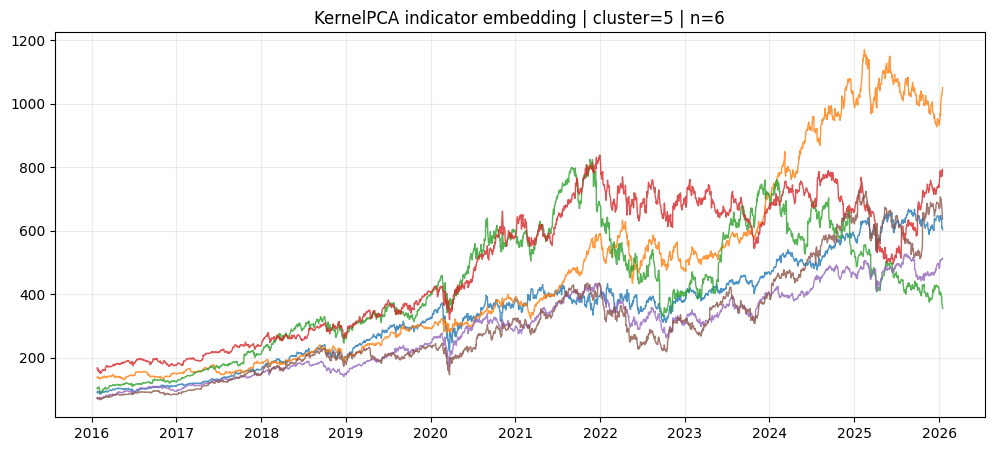

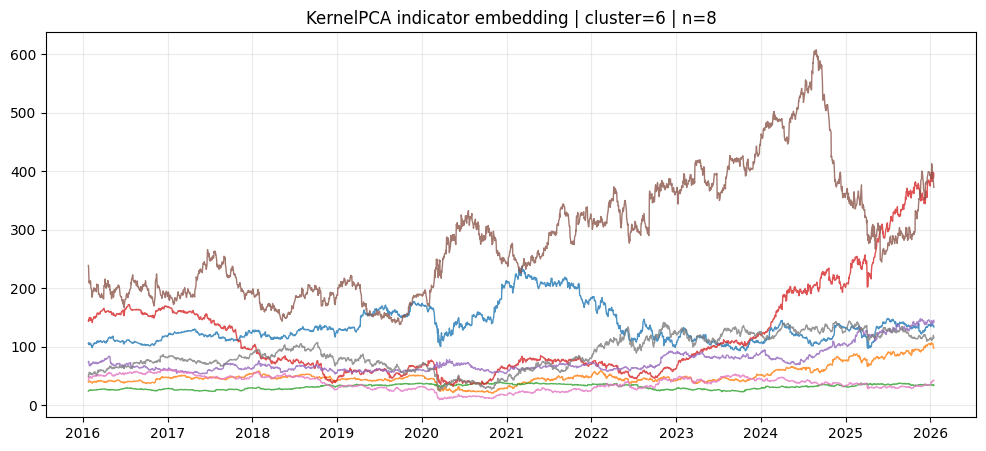

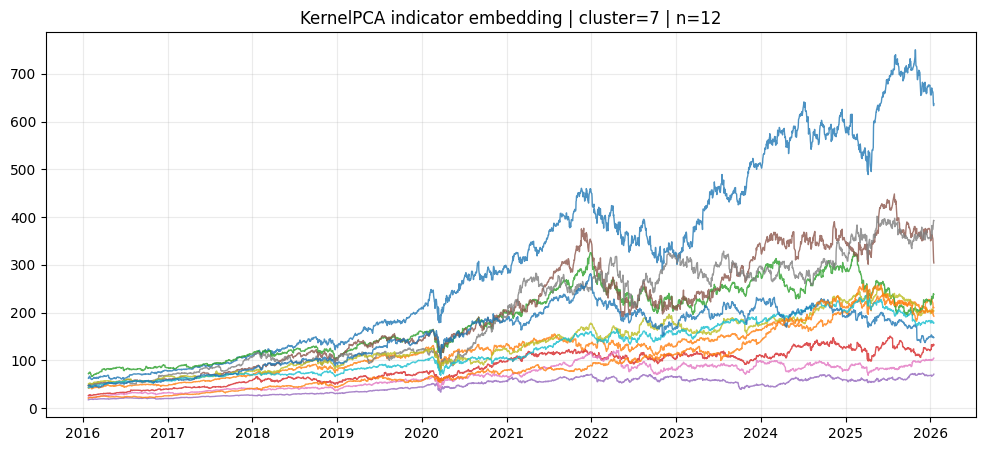

In [11]:
# Plot daily close prices for each cluster group
from src.backtester.data import load_cleaned_assets, align_close_prices

assets_ohlcv = load_cleaned_assets(cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_daily = align_close_prices(assets_ohlcv).sort_index()

for cid in sorted(groups.keys()):
    syms = groups[cid]
    dfp = close_daily.loc[:, [s for s in syms if s in close_daily.columns]].dropna(how='all')
    if dfp.empty:
        continue

    plt.figure(figsize=(12, 5))
    for s in dfp.columns:
        plt.plot(dfp.index, dfp[s].astype(float), linewidth=1.0, alpha=0.8)
    plt.title(f'KernelPCA indicator embedding | cluster={cid} | n={len(syms)}')
    plt.grid(True, alpha=0.25)
    plt.show()
